# Introduction

Suite à notre analyse précédente basée sur le clustering K-means (3_ACP_K-means_Amazing), bien que certains groupes d'utilisateurs aient pu être identifiés, les résultats obtenus ne sont pas entièrement satisfaisants. En effet, la segmentation basée sur les variables comportementales telles que le nombre de sessions, la valeur totale des achats, et le score de fidélité a révélé des différences significatives entre certains clusters. Cependant, ces clusters ne semblent pas capturer de manière optimale les nuances dans le comportement des utilisateurs, notamment en ce qui concerne leur engagement et leur contribution à la performance globale.

Ainsi, pour mieux comprendre nos utilisateurs et proposer des actions marketing plus pertinentes, nous devons envisager une autre approche plus adaptée à la dynamique de la clientèle d'Amazing. La méthode de Segmentation RFM (Récence, Fréquence, Valeur Monétaire), largement reconnue dans les stratégies de fidélisation et de gestion de la relation client, s'avère être une alternative particulièrement intéressante.

### Étapes pour appliquer la méthode RFM :
1. **Récence (Recency)** : Nombre de jours depuis la dernière interaction ou achat.
2. **Fréquence (Frequency)** : Nombre de fois qu'un utilisateur a interagi ou acheté.
3. **Valeur Monétaire (Monetary Value)** : Montant total dépensé par l'utilisateur.

### Calcul des Scores RFM :
1. **Récence** : Utiliser la colonne `days_since_last_purchase`.
2. **Fréquence** : Utiliser les colonnes de fréquence des interactions (`number_of_sessions_2m`, `number_of_sessions_5m`, etc.).
3. **Valeur Monétaire** : Utiliser `total_purchase_value`.


En conséquence, nous allons explorer cette méthode pour obtenir une segmentation plus pertinente et alignée sur nos objectifs commerciaux.


In [4]:
# Importation des bibliothèques nécessaires 

import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
# import requests
# import io
# from urllib.parse import urljoin

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.tree import plot_tree

In [2]:
# # URL directe vers le fichier Parquet sur GitHub
# base_url = "https://github.com/EricIrjam/e-amazing/raw/main/data/user_stats_df_output.parquet/"


In [3]:
# # Fonction pour récupérer et lire tous les fichiers .parquet dans le répertoire
# def read_parquet_files(base_url):
#     # Les fichiers que nous devons récupérer
#     file_names = [
#         f"part-0000{i}-9b319896-debc-49c4-b0a7-fbbd59863d51-c000.snappy.parquet" for i in range(5)
#     ]

#     # Lire et combiner tous les fichiers Parquet en un seul DataFrame
#     tables = []
#     for file_name in file_names:
#         file_url = urljoin(base_url, file_name)
#         response = requests.get(file_url)
#         response.raise_for_status()

#         # Lire le fichier Parquet
#         table = pq.read_table(io.BytesIO(response.content))
#         tables.append(table)

#     # Combiner toutes les tables en une seule
#     combined_table = pa.concat_tables(tables)
#     return combined_table.to_pandas()

In [5]:
# Charger les données à partir du fichier Parquet
df = pd.read_parquet('/app/data/full_df_output.parquet')

# Mise en œuvre de la segmentation RFM et évaluation des clusters


In [6]:

# Calcul des scores RFM
# Recency : on utilise la colonne 'days_since_last_purchase' (moins c'est élevé, mieux c'est)
df['R_Score'] = pd.qcut(df['days_since_last_purchase'], q=4, labels=[4, 3, 2, 1])

# Frequency : on utilise les sessions des 7 derniers mois (plus c'est élevé, mieux c'est)
df['F_Score'] = pd.qcut(df['number_of_sessions_7m'], q=4, labels=[1, 2, 3, 4])

# Monetary Value : on utilise la colonne 'total_purchase_value' (plus c'est élevé, mieux c'est)
df['M_Score'] = pd.qcut(df['total_purchase_value'], q=4, labels=[1, 2, 3, 4])

# Préparation des données pour le clustering
X = df[['R_Score', 'F_Score', 'M_Score']].astype(int)

# Calcul de l'indice de silhouette pour différents nombres de clusters
silhouette_scores = []
range_n_clusters = range(3, 15)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)



# Visualisation de l'évolution de l'indice de silhouette en fonction du nombre de clusters

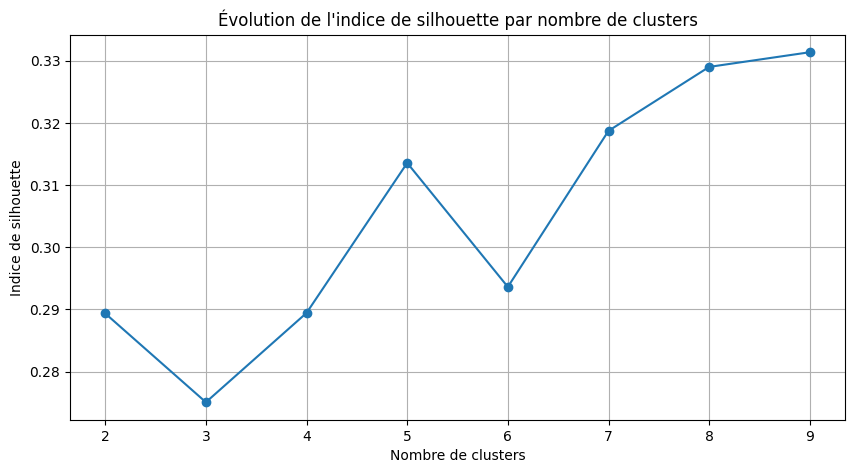

In [6]:
# Graphique de l'évolution de l'indice de silhouette
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Évolution de l'indice de silhouette par nombre de clusters")
plt.xlabel("Nombre de clusters")
plt.ylabel("Indice de silhouette")
plt.grid(True)
plt.show()



1. **Indice de silhouette** :
   - Un indice de silhouette proche de 1 indique que les clusters sont bien séparés et denses.
   - Un indice proche de 0 signifie que les clusters se chevauchent ou ne sont pas clairement distincts.
   - Des valeurs négatives (bien qu'il n'y en ait pas ici) indiquent que des points sont probablement affectés au mauvais cluster.

2. **Nombre de clusters optimal** :
   Nous observons un pic de l'indice de silhouette autour de 5 clusters, ce qui nous fait penser que 5 clusters pourraient être un bon choix pour une segmentation optimale selon cet indicateur. Cependant, Si nous souhaitons aller plus loin dans la granularité de l'analyse, tester avec 8 ou 9 clusters pourrait nous offrir une segmentation plus détaillée des clients, en prenant en compte des critères comme les gammes de produits ou la fréquence des achats.



In [16]:
# Clustering avec le nombre optimal de clusters trouvé (exemple : 6 clusters)
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Visualisation 3D du clustering RFM avec le nombre optimal de clusters

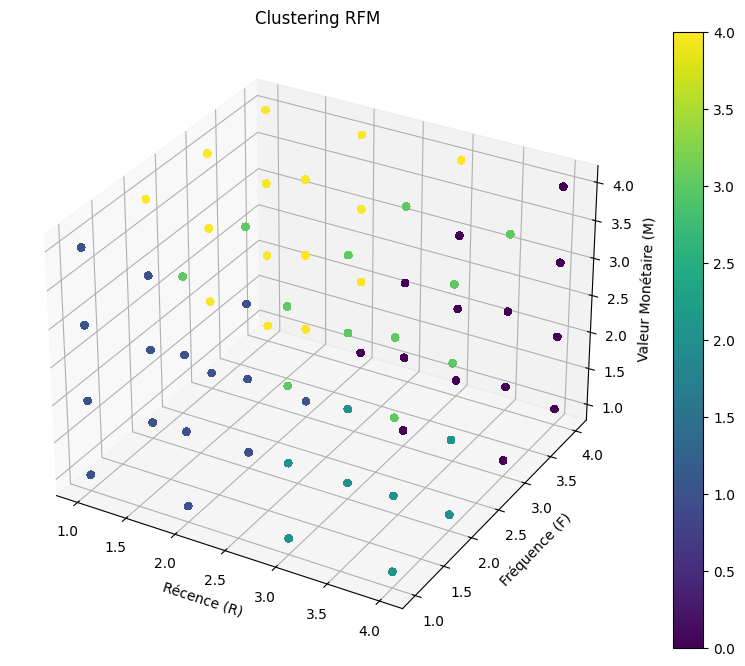

In [17]:


# Graphique 3D du clustering
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['R_Score'], df['F_Score'], df['M_Score'], c=df['cluster'], cmap='viridis')

# Titres et labels
ax.set_title('Clustering RFM')
ax.set_xlabel('Récence (R)')
ax.set_ylabel('Fréquence (F)')
ax.set_zlabel('Valeur Monétaire (M)')
plt.colorbar(scatter)
plt.show()


#  Séparation des données et de la cible pour le modèle de classification 


In [18]:
X = df[['R_Score', 'F_Score', 'M_Score']]  # Caractéristiques RFM
y = df['cluster']  # Cible : cluster attribué

In [19]:
# Division des données en ensembles d'entraînement et de test
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Création et entraînement du modèle Decision Tree

In [20]:

tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(data_train, target_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

#  Prédiction sur l'ensemble de test 

In [21]:

predictions = tree.predict(data_test)

# Évaluation du modèle (accuracy) 

In [22]:

accuracy = accuracy_score(target_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.92


# Afficher le rapport de classification et la matrice de confusion



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      3166
           1       0.91      0.97      0.94      3868
           2       1.00      1.00      1.00      2944
           3       0.72      1.00      0.84      2719
           4       1.00      0.84      0.91      4276

    accuracy                           0.92     16973
   macro avg       0.93      0.92      0.92     16973
weighted avg       0.94      0.92      0.92     16973


Confusion Matrix:


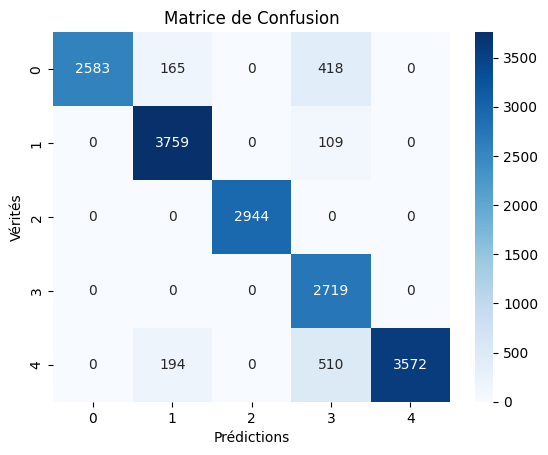

In [23]:
print("\nClassification Report:")
print(classification_report(target_test, predictions))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(target_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.show()

La matrice de confusion, nous pouvons tirer quelques conclusions intéressantes sur la performance de notre modèle de classification. 

Tout d'abord, nous remarquons que pour la classe 0, bien que le modèle ait correctement prédit 2583 instances, il a encore 418 erreurs où les prédictions sont allées vers la classe 3. 
Cela signifie que nous avons un certain chevauchement entre ces classes. Pour la classe 1, le modèle est assez performant avec seulement 109 erreurs, ce qui se reflète bien dans le score de rappel de 0.97 dans notre rapport de classification.

Pour la classe 2, les résultats sont presque parfaits avec aucune confusion, ce qui explique la précision et le rappel de 1.00 pour cette classe. Cependant, pour la classe 3, même si le rappel est élevé (1.00), la précision est plus faible (0.72), ce qui indique que de nombreuses instances de la classe 4 sont confondues avec la classe 3, comme nous pouvons le voir avec les 510 prédictions incorrectes.

Enfin, pour la classe 4, bien que la précision soit élevée (1.00), le modèle a encore du mal à différencier cette classe des autres, notamment avec les 194 instances mal classées comme 1 et 510 instances mal classées comme 3.

<div style="border: 1px solid #B0E0E6; padding: 10px; background-color: #E0FFFF;"> 

Globalement, avec une précision pondérée de **0.94** et une exactitude de **0.92**, nous pouvons être satisfaits des performances du modèle, mais il y a encore des améliorations à faire, notamment dans la distinction entre les classes 3 et 4.

</div> 

# Visualisation de l'arbre de décision


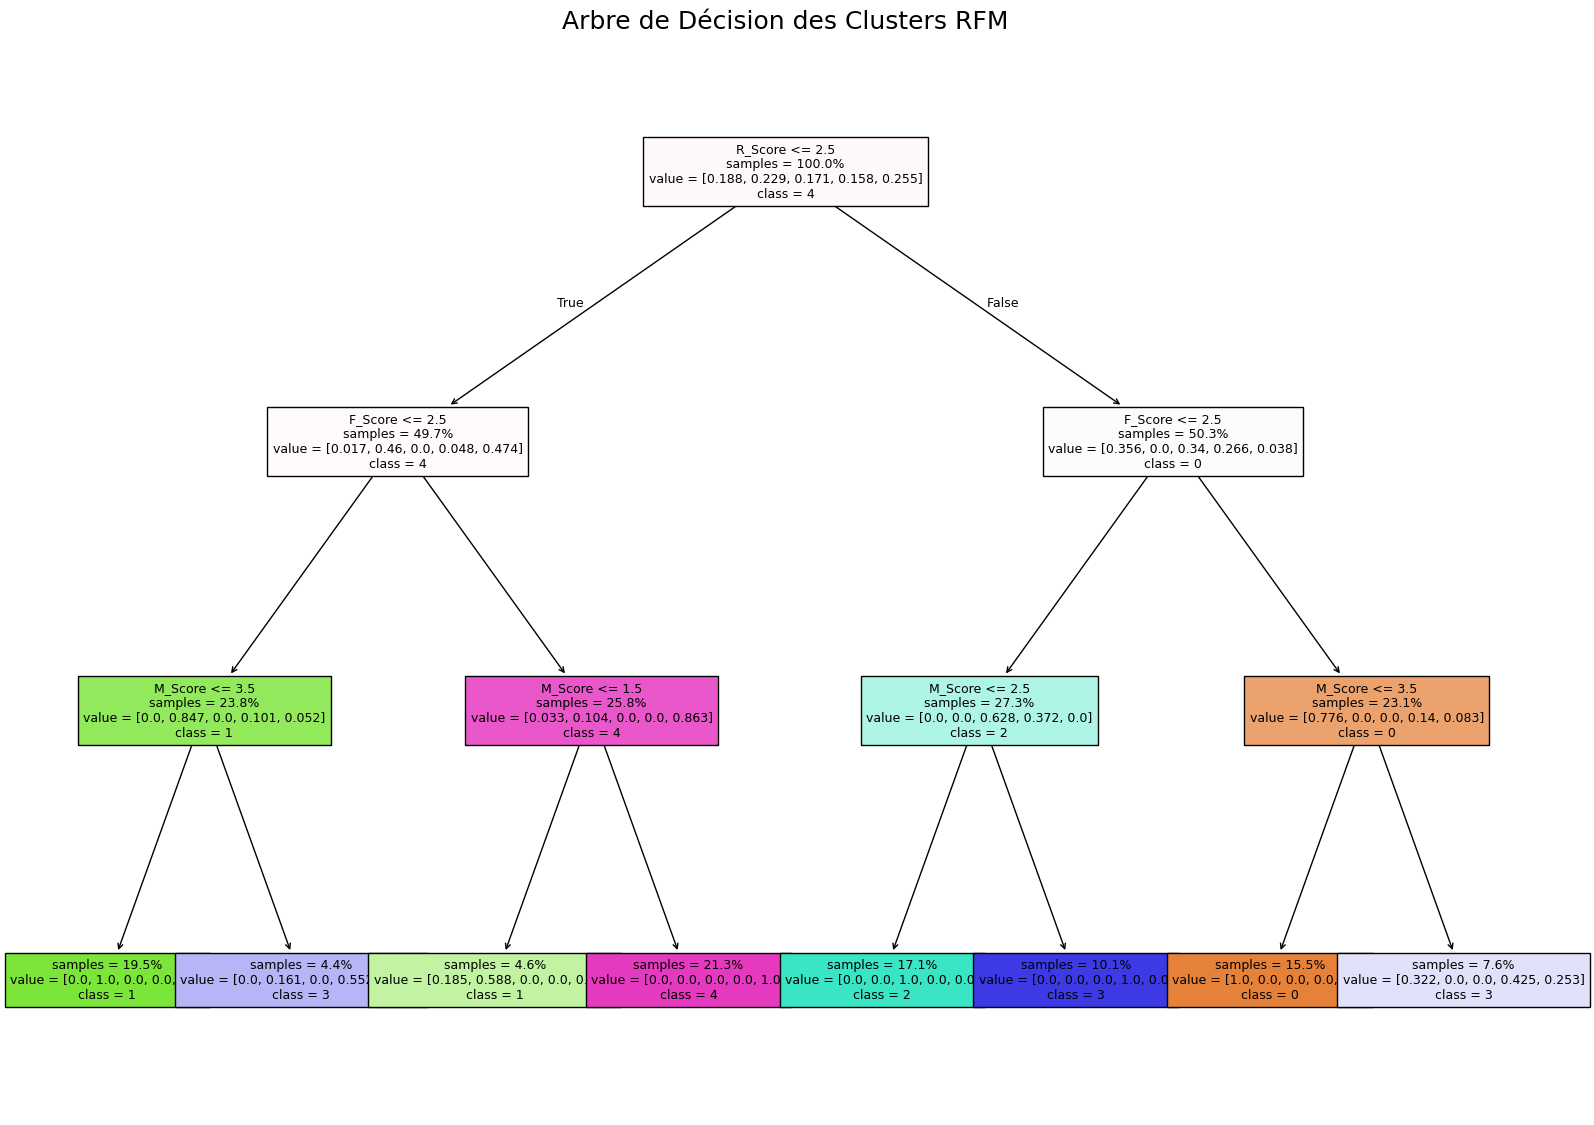

In [24]:
# Entraînement de l'arbre de décision (comme dans la partie précédente du code)
# Nommons l'arbre de décision "clf" pour éviter le conflit avec le module "tree"
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(data_train, target_train)

# Définir les noms des features et des classes pour l'affichage de l'arbre
feature_names = ['R_Score', 'F_Score', 'M_Score']
class_names = [str(cls) for cls in clf.classes_]  # Utiliser l'objet "clf" qui a été formé

# Visualisation de l'arbre de décision avec une taille de figure ajustée
_, ax = plt.subplots(figsize=(20, 14), dpi=100)  # Augmentation de la taille et de la résolution de la figure
plot_tree(
    clf,  # Utilisation du modèle "clf" ici
    feature_names=feature_names,
    class_names=class_names,
    impurity=False,
    filled=True,
    ax=ax,
    fontsize=9, 
    proportion=True
)

plt.title('Arbre de Décision des Clusters RFM', fontsize=18)
plt.show()



En regardant cet arbre de décision, nous pouvons associer différents groupes de clients à des animaux pour mieux visualiser leurs comportements :

- Tout d'abord, pour les clients avec un **R_Score ≤ 2.5**, ce qui signifie qu’ils ne sont pas très récents, nous pouvons les comparer à des **hiboux 🦉**. Ces clients sont plus discrets, moins actifs, et se trouvent majoritairement dans la classe 4. Certains, comme ceux avec un **F_Score ≤ 2.5** et un **M_Score ≤ 3.5**, peuvent être des **ours en hibernation 🐻**. Ils reviennent de temps en temps, mais ne dépensent pas énormément.

- Ensuite, pour les clients avec un **F_Score élevé** mais un faible **M_Score** (≤ 1.5), nous avons des **écureuils 🐿️**. Ces clients reviennent fréquemment, mais leurs achats sont modestes, un peu comme un écureuil qui accumule de petites quantités.

- Pour ceux avec un **R_Score élevé** (plus récents) et un **M_Score > 3.5**, nous sommes en présence de **lions 🦁**. Ces clients sont puissants et font des achats importants, bien qu'ils soient plus récents. Ils dominent la scène dans les classes 0 et 2. Ce sont les clients à chouchouter, car ils ont un potentiel de valeur élevé.

- Enfin, les clients dans les classes 3 et 2, avec un **F_Score ≤ 2.5**, peuvent être comparés à des **renards 🦊**. Ils ne reviennent pas très souvent, mais lorsqu'ils le font, ils dépensent un montant considérable, ce qui en fait des cibles intéressantes pour nos stratégies marketing.

<div style="border: 1px solid #B0E0E6; padding: 10px; background-color: #E0FFFF;"> 

En somme, cet arbre nous permet d'identifier et de comprendre la diversité des comportements de clients en fonction de leur récence, fréquence et montant. Les **hiboux 🦉** et **ours en hibernation 🐻** nécessitent peut-être des efforts de réactivation, tandis que les **lions 🦁** et **renards 🦊** sont des clients à haute valeur que nous devons fidéliser avec soin.

</div> 